##### Imports and initialization

In [1]:
%matplotlib inline

import os,sys
#path = os.path.realpath(os.path.join(os.getcwd(), ".."))
path = "/home/zantyr/Denoising"
sys.path.append(path)
os.chdir(path)

import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.io.wavfile as sio
import tempfile

from IPython.display import Image, Audio, display

import keras
from keras.utils.vis_utils import plot_model
from keras.layers         import Dropout, Input, Conv1D, Conv2D, AveragePooling2D, Flatten, Dense, Deconv2D, UpSampling2D, concatenate, BatchNormalization, Lambda, LeakyReLU, TimeDistributed, Reshape, LSTM, GaussianNoise
from keras.models         import Model
from keras.datasets.mnist import load_data
from keras.utils          import to_categorical
from keras.initializers   import Orthogonal
from keras.regularizers   import L1L2, l2
from keras.callbacks      import Callback
import keras.backend as K
import tensorflow as tf

import loaders
from loaders.transform import AddGaussianNoise, Windowing, GSMize, MixReverb, MixNoise, ConstantQTransform, Transcript, LengthOfWindow, Length, Lengthen, Null, DivisiblePad
from loaders.dataset import Dataset, enable_multiprocessing, disable_multiprocessing
from loaders.feature import NormalizedLogPowerRFFT, Trim
from loaders.experiment import SingleExperiment
from loaders.measures import MSE
from loaders.schedule import Schedule
from loaders.estimator import DefaultVisualizeTransform, Estimator
from loaders.extras import LossHistory, set_device, delog_griffin_lim, get_stft
from loaders.custom import identity_loss
set_device()               # switches to CPU if GPU busy
enable_multiprocessing()   # for faster preprocessing of data (multicore)

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Switching to CPU only as GPU is busy or unavailable


Process ForkPoolWorker-3:
Traceback (most recent call last):
Process ForkPoolWorker-7:
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-6:
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-2:
  File "/usr/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
Process ForkPoolWorker-9:
  File "/usr/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/queues.py", line 345, in get
    with s

### After reset

##### Load models and data

In [28]:
# import from first cell after restarting kernel

# ["baseline", "simplified baseline", "dense AE", "conv/dense separated axes", "conv/dense common axes", "separate axes AE"]

"""
experiment_names = ['./runs/1538495798.0744123',
 './runs/1538504597.4488058',
 './runs/1538507862.4013004',
 './runs/1538512005.2587183',
 './runs/1538518712.1716878',
 './runs/1538534130.8271744']
"""

# ["baseline", "conv/dense separated axes", "conv/dense common axes", "separate axes AE"]


experiment_names = [
 './runs/1540811443.31866',
 './runs/1538495798.0744123',
 './runs/1538512005.2587183',
 './runs/1538518712.1716878',
 './runs/1538534130.8271744',
 './runs/1540816118.892748']

In [2]:
with open("/tmp/test_data.bin", "rb") as f:
    test, phase = pickle.load(f)
    
with open("/tmp/data_norm.bin", "rb") as f:
    MEAN, STD = pickle.load(f) #, phase = pickle.load(f)

['results.pkl', 'model.h5', 'history.pkl']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, 129, 15)     225       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1935)        0         
_________________________________________________________________
dense_5 (Dense)              (None, None, 2048)        3964928   
_________________________________________________________________
hidden (Dense)               (None, None, 2048)        4196352   
_________________________________________________________________
dense_6 (Dense)              (Non

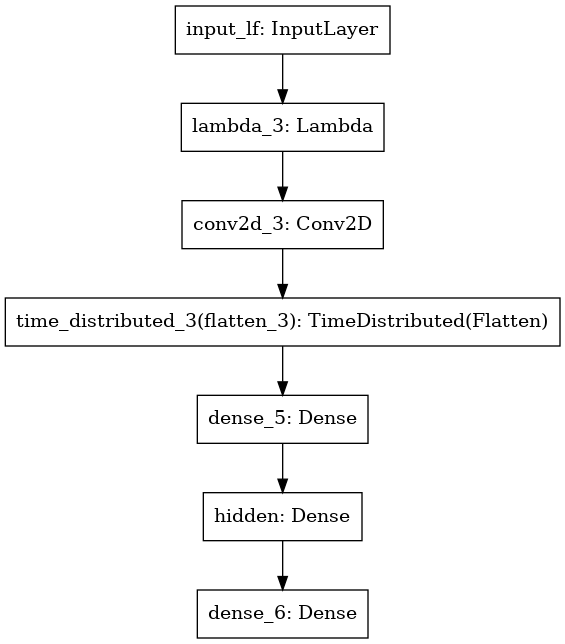

['results.pkl', 'model.h5', 'history.pkl']


/usr/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, None, 129, 32 320         lambda_13[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_69 (LeakyReLU)      (None, None, 129, 32 0           conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_34 

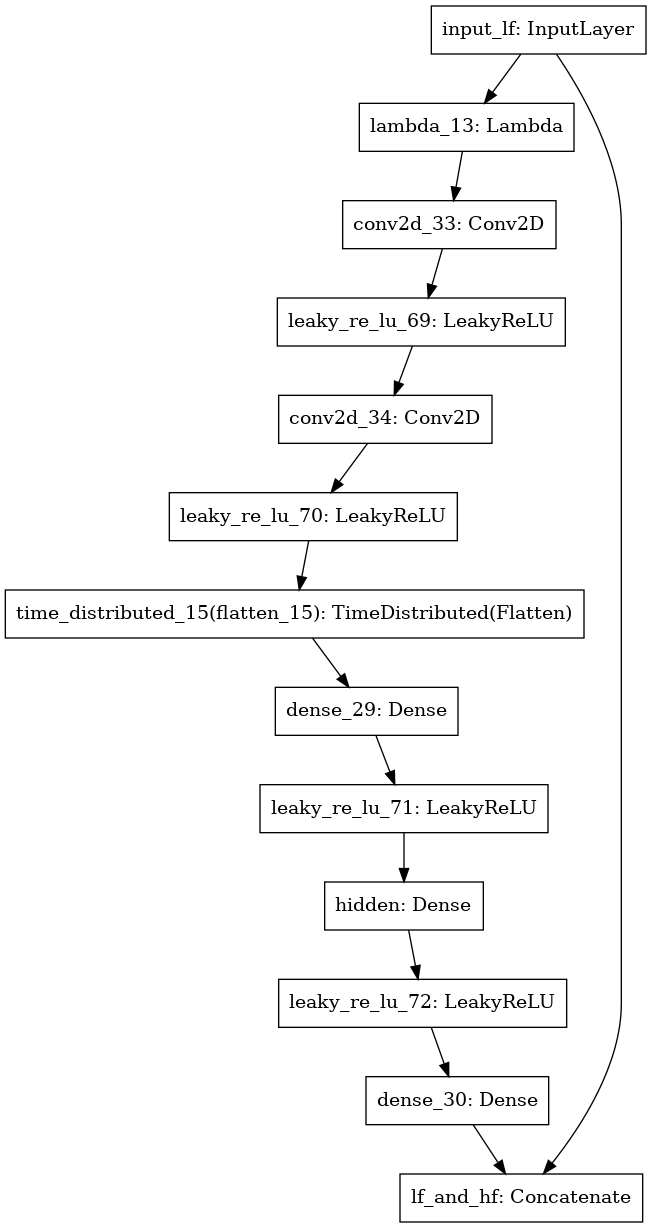

['results.pkl', 'model.h5', 'history.pkl']


/usr/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, None, 129, 16 160         lambda_16[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_83 (LeakyReLU)      (None, None, 129, 16 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 

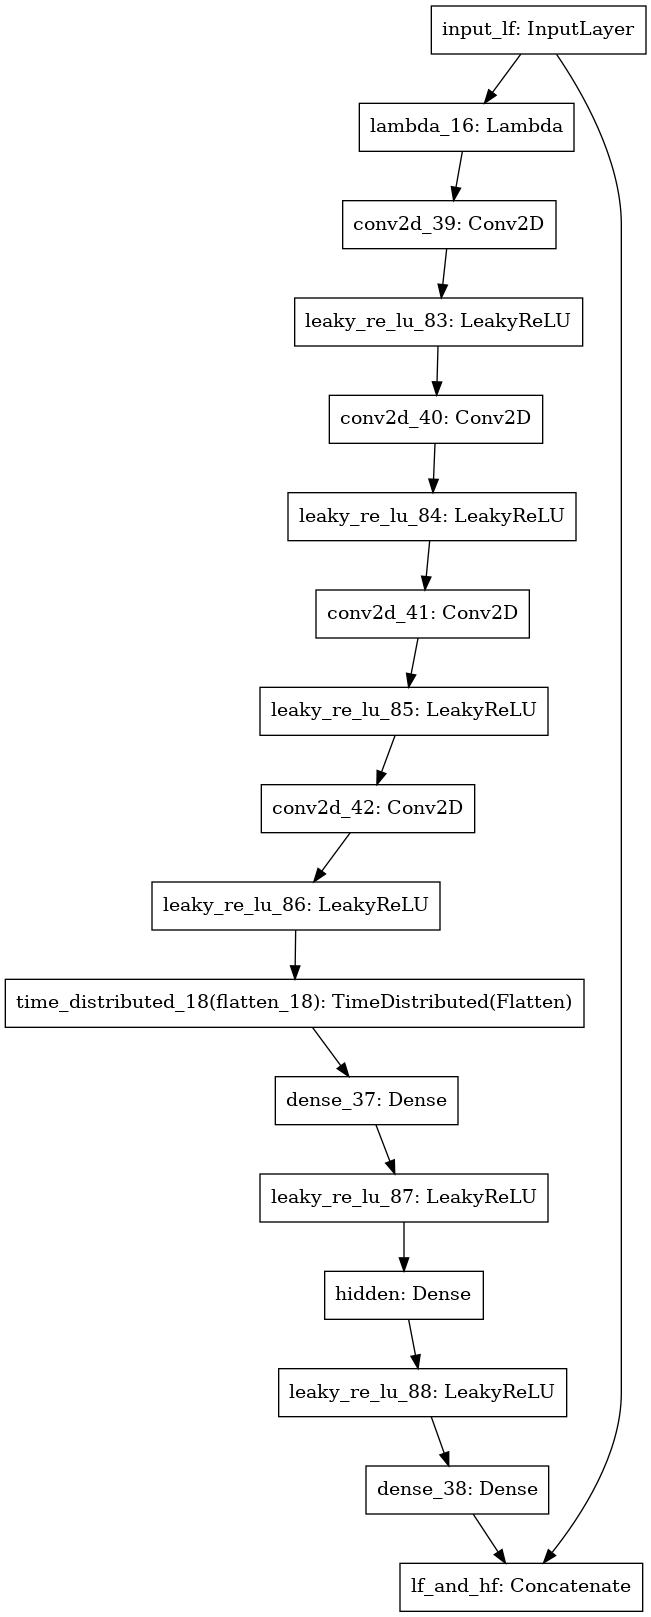

['results.pkl', 'model.h5', 'history.pkl']


/usr/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, None, 129, 32 1472        lambda_17[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_89 (LeakyReLU)      (None, None, 129, 32 0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_44 

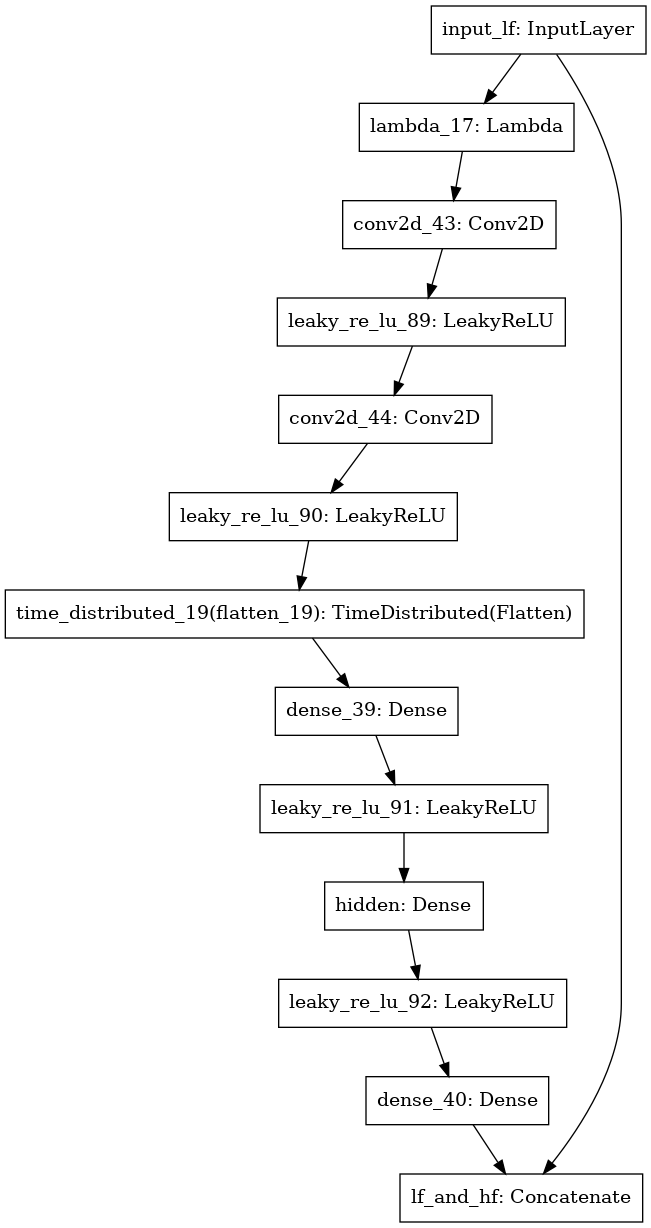

['results.pkl', 'model.h5', 'history.pkl']


/usr/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, None, 129, 16 160         lambda_18[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_93 (LeakyReLU)      (None, None, 129, 16 0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_46 

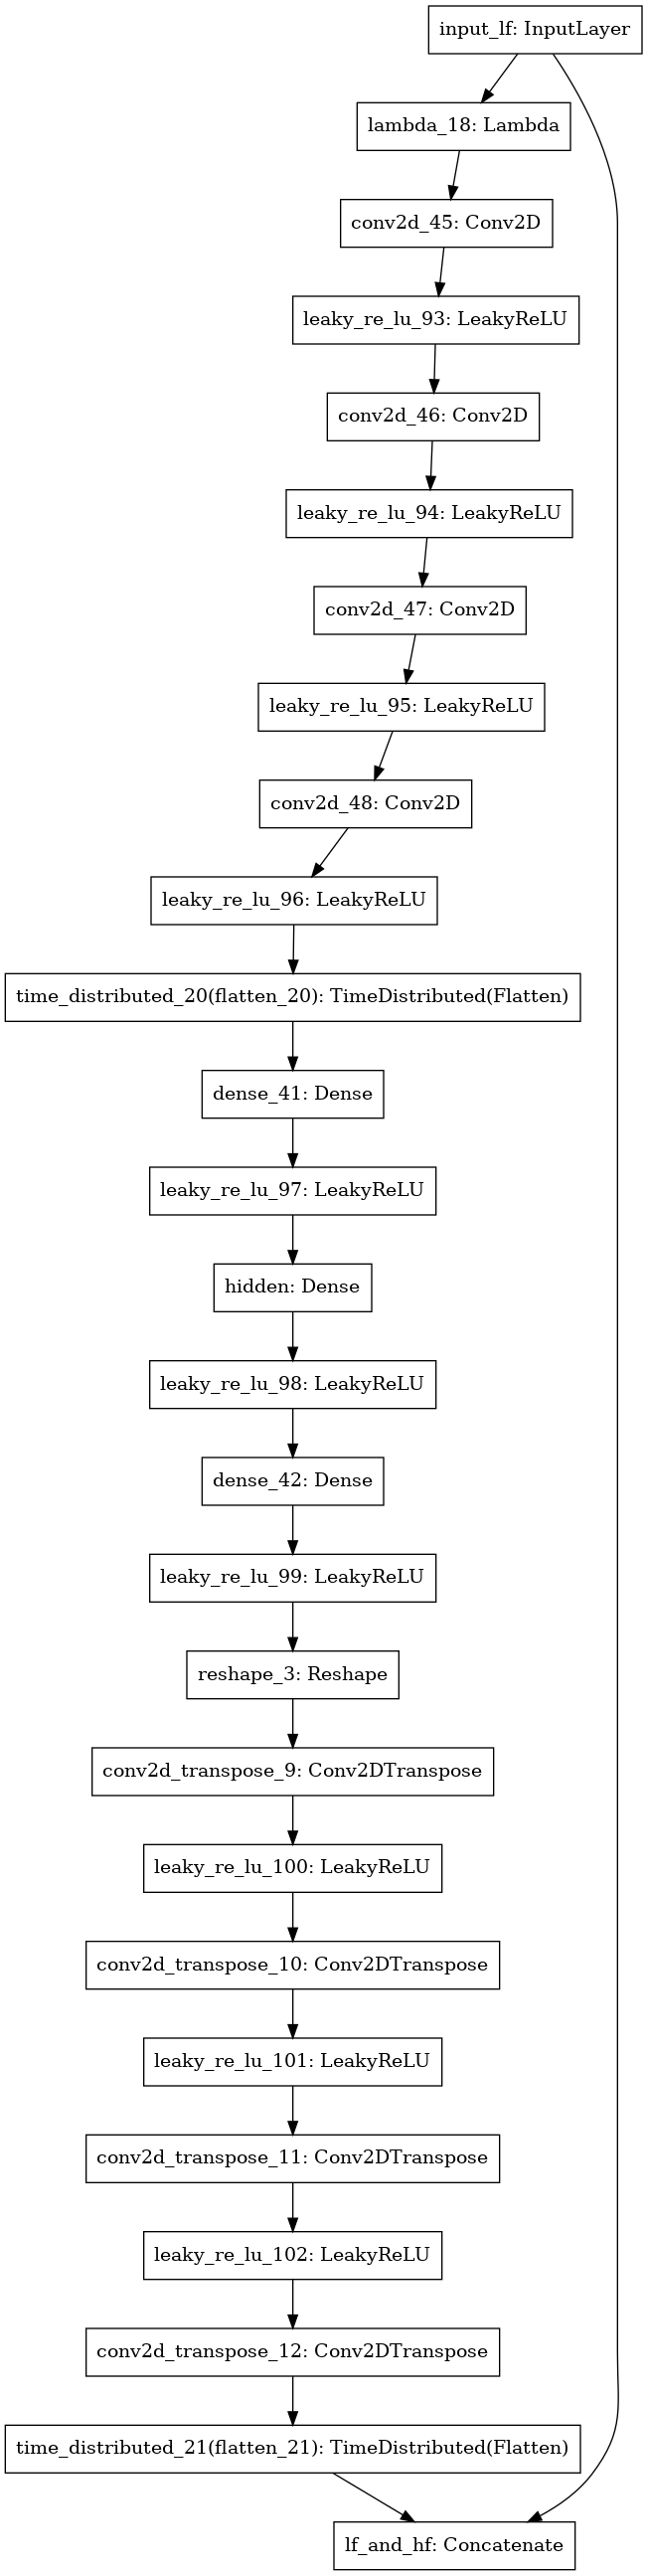

['results.pkl', 'model.h5', 'history.pkl']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, None, 129, 15 225         lambda_6[0][0]                   
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, None, 1935)   0           conv2d_6[0][0]                   
__________________________________________________________________

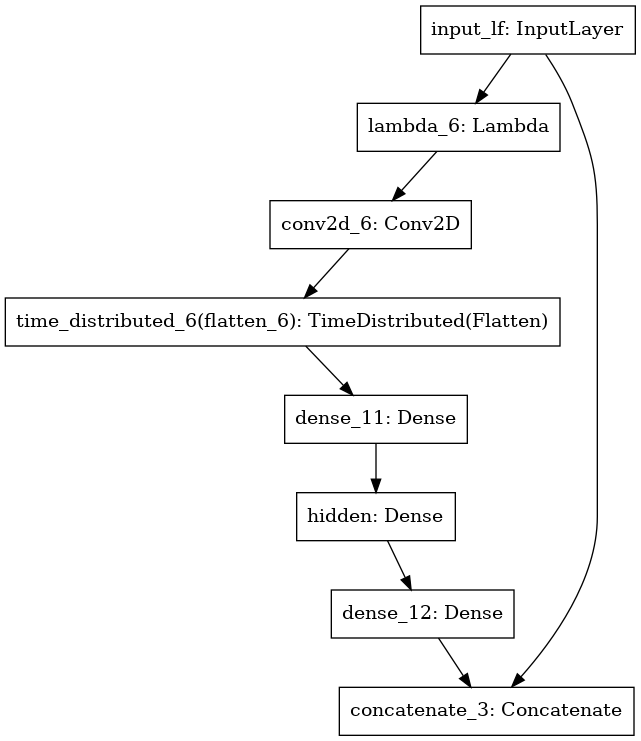

In [29]:
models = []

for model in experiment_names:
    mdl = Estimator.only_model(model)
    mdl.summary()
    print("-----\n" + model)
    models.append(mdl)
    try:
        temp = tempfile.mktemp() + ".png"
        plot_model(mdl, to_file=temp)
        display(Image(filename=temp))
    except:
        pass

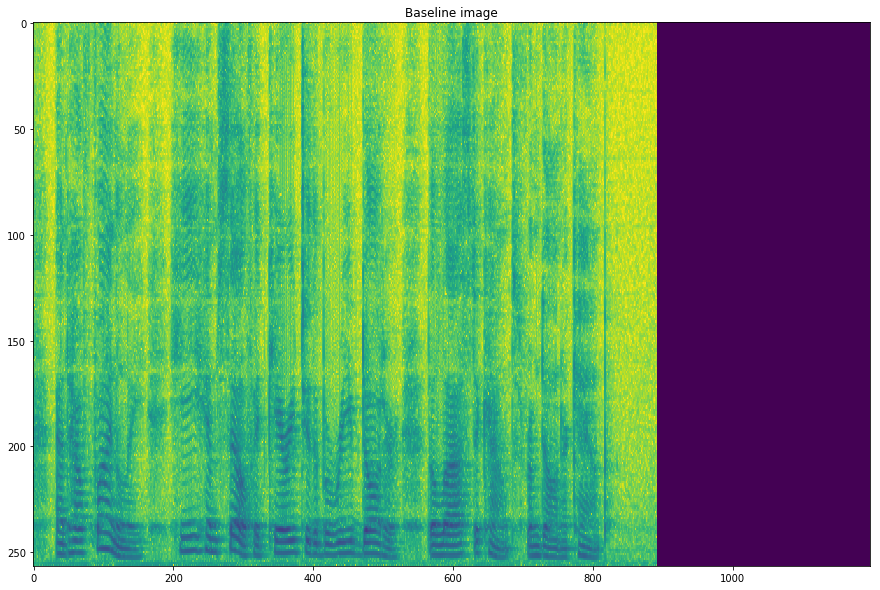

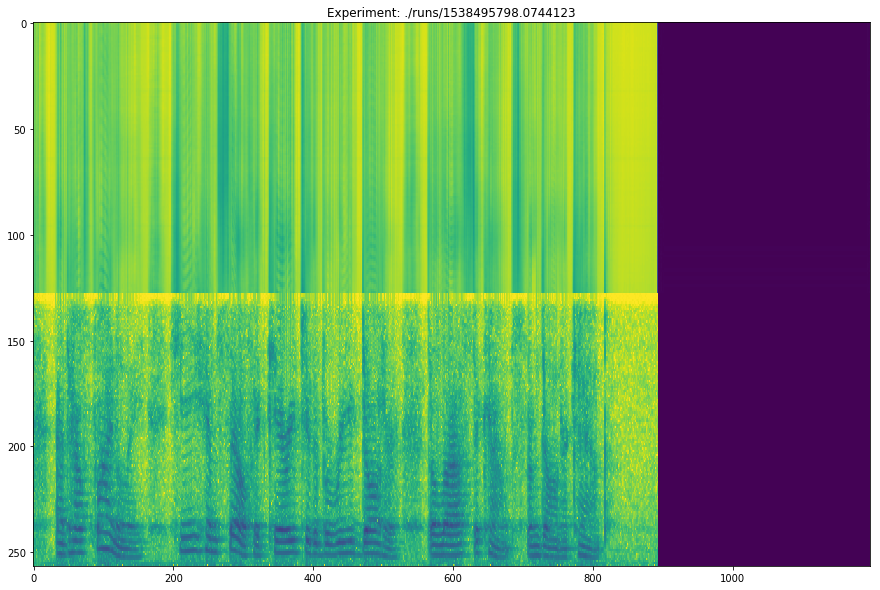

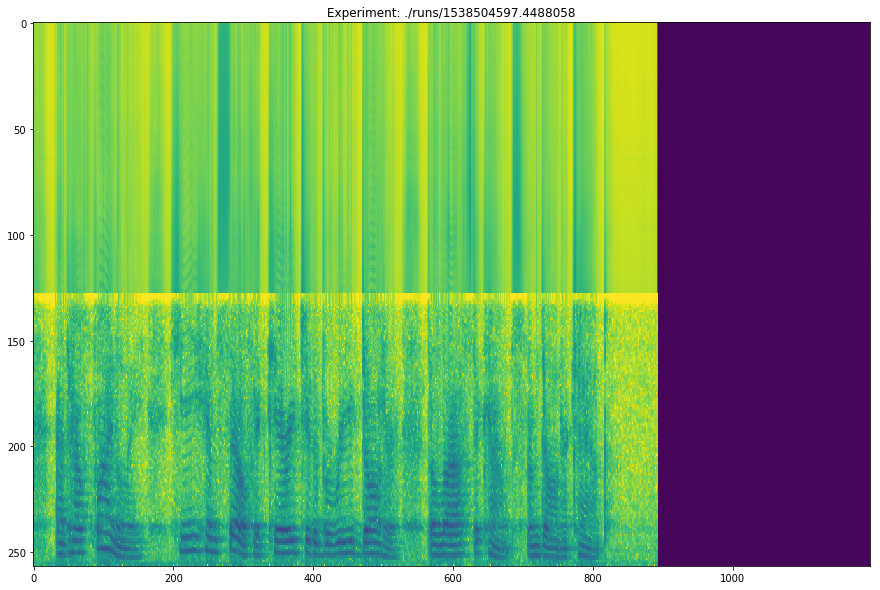

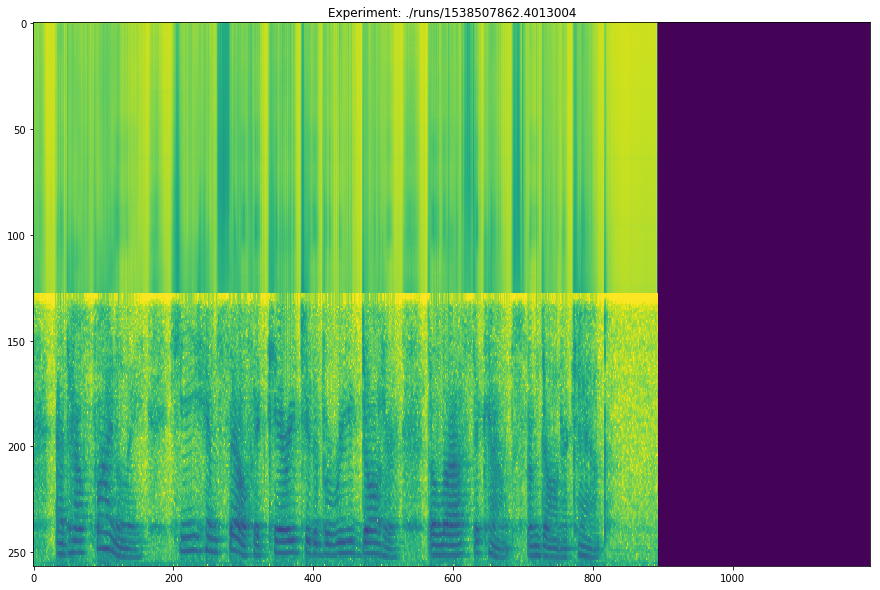

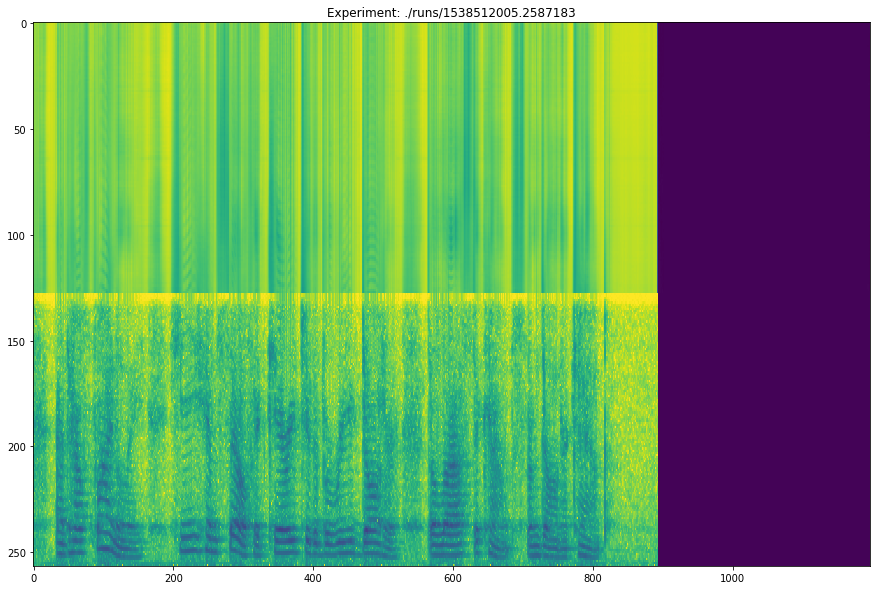

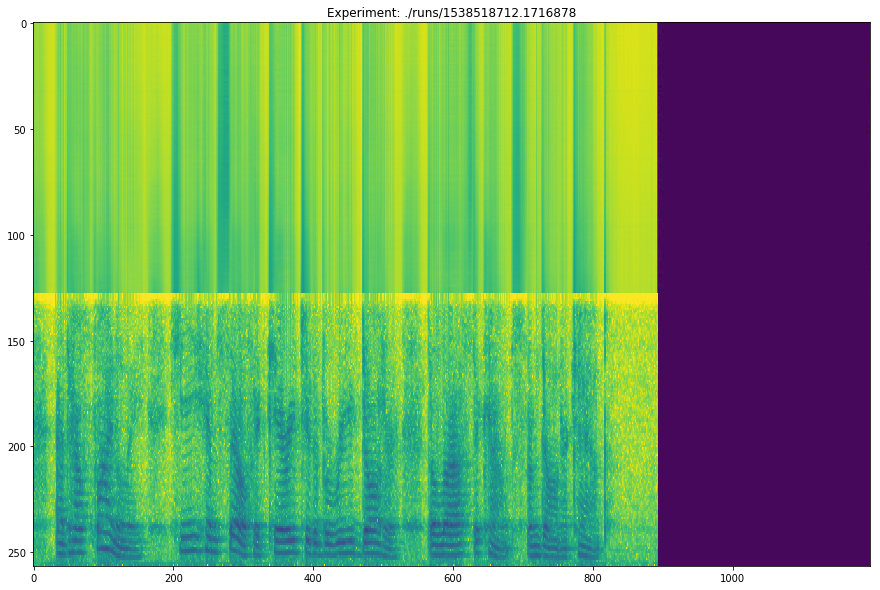

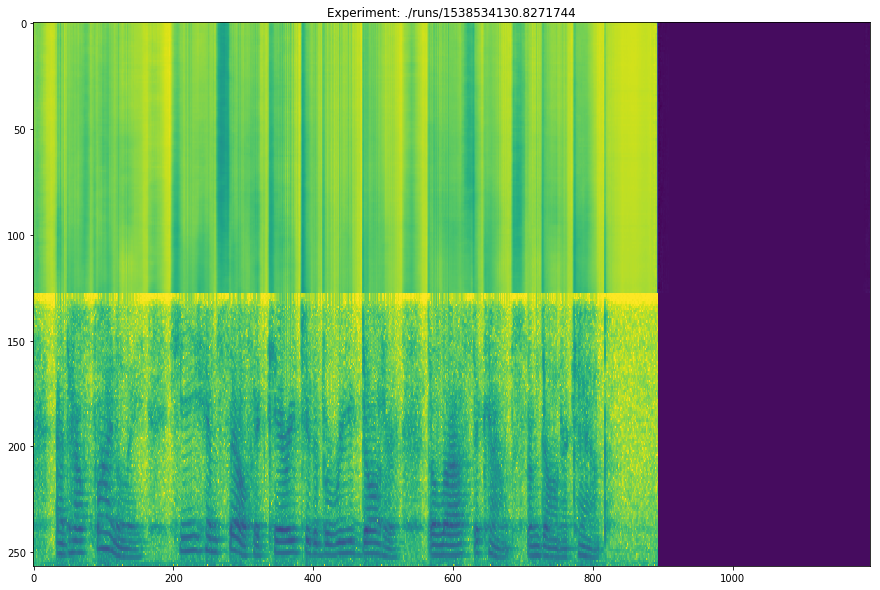

In [5]:
# visualisation

image, gt = test

plt.figure(figsize=(15,10))
plt.title("Baseline image")
plt.imshow(np.rot90(gt[0, :, :]), aspect='auto')
plt.show()

for name, mdl in zip(experiment_names, models):
    prediction = mdl.predict(image[:1])
    plt.figure(figsize=(15,10))
    plt.title("Experiment: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.show()

Groundtruth signal


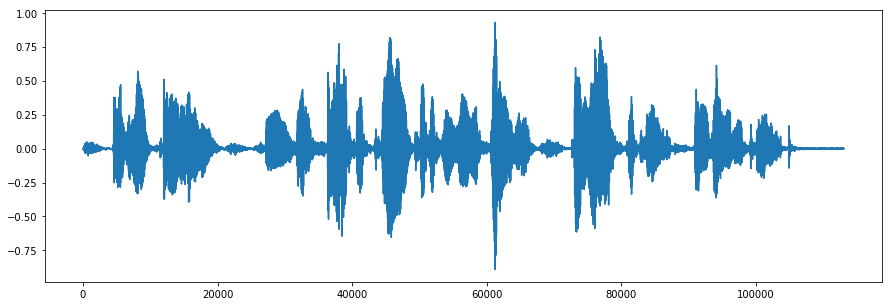

Input signal


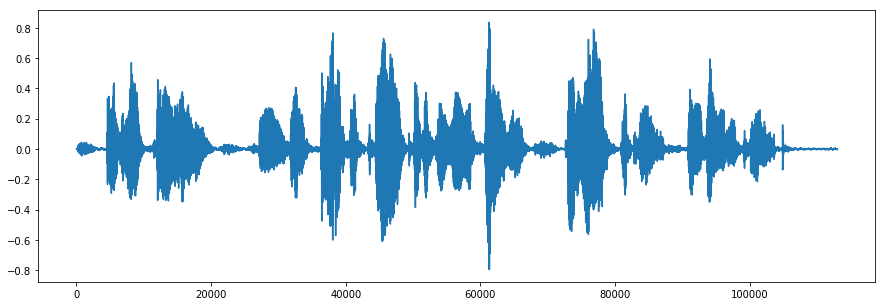

Prediction of ./runs/1538495798.0744123


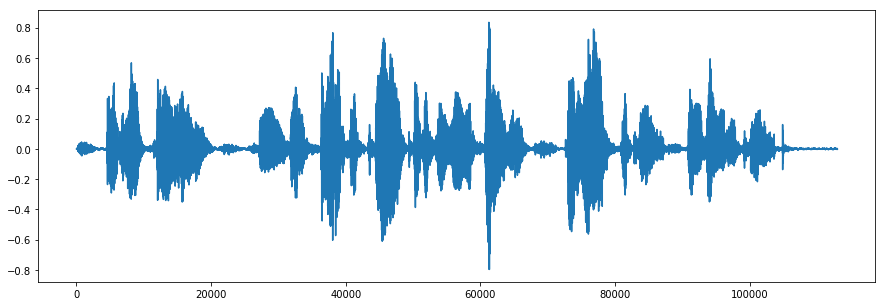

Prediction of ./runs/1538504597.4488058


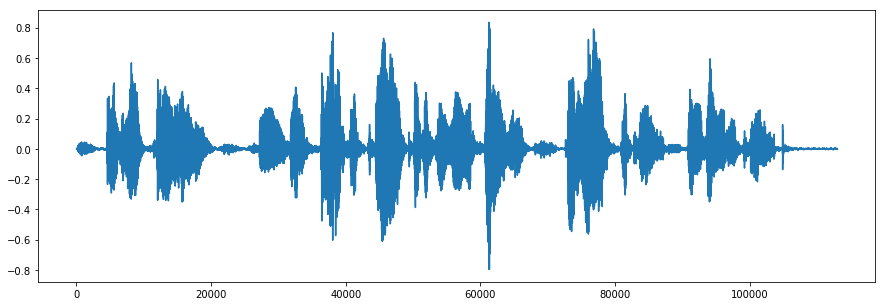

Prediction of ./runs/1538507862.4013004


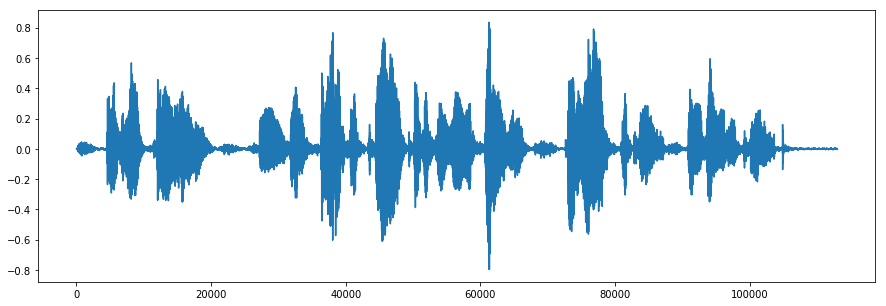

Prediction of ./runs/1538512005.2587183


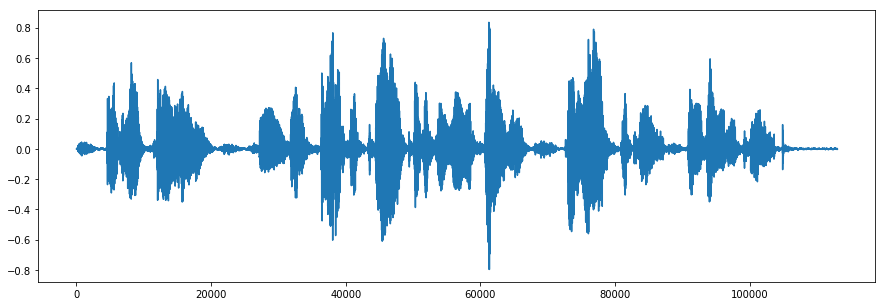

Prediction of ./runs/1538518712.1716878


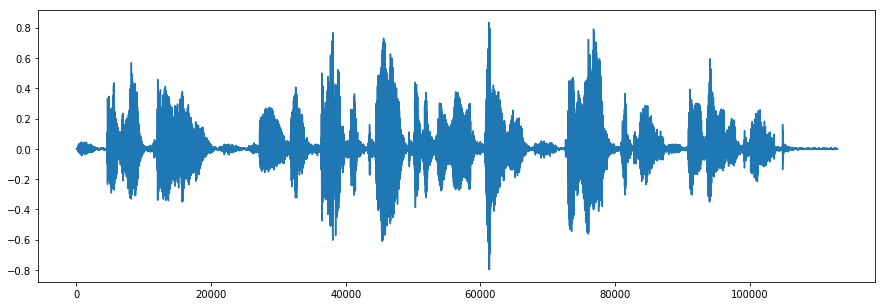

Prediction of ./runs/1538534130.8271744


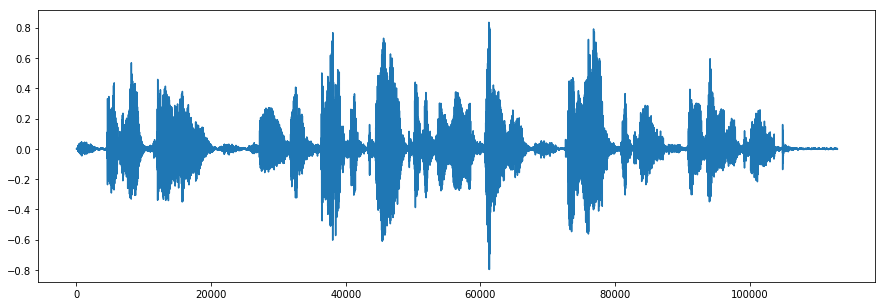

In [9]:
# predicted spectrograms

old_phase = phase.copy()
phase = gt[:] * 0
phase[:, :, :129] = old_phase[:, :, :129]
phase[:, :, 129:] = old_phase[:, :, 128:0:-1]
window = np.hamming(512)

print("Groundtruth signal")
sound = gt[0] * STD + MEAN
spec = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :] * 1j)
length = len(np.where((gt[0, :, :] != 0).sum(1))[0]) - 4
sound = np.zeros(length * 128 + 512 - 128)
for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound[:-1024])
plt.show()
display(Audio(sound[:-1024], rate=16000))

print("Input signal")
sound = image[0] * STD + MEAN
spec = np.zeros(gt[0].shape, np.complex)
spec[:,:129] = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :129] * 1j)
sound = np.zeros(length * 128 + 512 - 128)
for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound[:-1024])
plt.show()
display(Audio(sound[:-1024], rate=16000))


for name, mdl in zip(experiment_names, models):
    print("Prediction of " + name)
    spec = mdl.predict(image[:1])[0]
    sound = np.zeros(length * 128 + 512 - 128)
    spec *= STD
    spec += MEAN
    spec = (np.sqrt(np.exp(-spec)) * 512) * np.exp(phase[0, :, :] * 1j)
    for i in range(length):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += window * frame
    plt.figure(figsize=(15,5))
    plt.plot(sound[:-1024])
    plt.show()
    display(Audio(sound[:-1024], rate=16000))


##### Metrics

In [6]:
import subprocess
import re

def pesq(gt, pred, phase):
    spec = (np.sqrt(np.exp(-gt)) * 512) * np.exp(phase * 1j)
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    spec = (np.sqrt(np.exp(-pred)) * 512) * np.exp(phase * 1j)
    sound2 = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound2[128 * i : 128 * i + 512] += frame
    fname_gt = tempfile.mktemp() + ".wav"
    fname_pred = tempfile.mktemp() + ".wav"
    # print(sound.shape, sound2.shape)
    sio.write(fname_gt, 16000, (2**15 * sound).astype(np.int16))
    sio.write(fname_pred, 16000, (2**15 * sound2).astype(np.int16))
    ot,e = subprocess.Popen(["PESQ", "+wb", "+16000", fname_gt, fname_pred], stdout = subprocess.PIPE, stderr = subprocess.PIPE).communicate()
    os.remove(fname_gt)
    os.remove(fname_pred)
    # print(ot)
    o = ot.decode("utf-8").split('\n')[-2]
    # print(o, len(o))
    # if not len(o):
    #     print(ot.decode("utf-8"))
    value = re.findall("= \d\.\d+", o)[0]
    # print(value)
    return float(value[2:])

inp, gtruth = test
n_phase = gtruth * 0
n_phase[:,:,:129] = phase[:]
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
quality = []
print(gtruth.shape, preds.shape, n_phase.shape)
gtruth = STD * gtruth + MEAN
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("No processing PESQ:", np.array(quality).mean())

quality_arrays = []

for name, mdl in zip(experiment_names, models):
    preds = np.zeros([gtruth.shape[0], 1248, 257], np.float32)
    for i in range(gtruth.shape[0]):
        preds[i] = mdl.predict(inp[i:i+1])
    preds[i]
    preds = STD * preds + MEAN
    quality = []
    for i in range(gtruth.shape[0]):
        try:
            quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
        except IndexError:
            print("Failed getting PESQ value for recording {}".format(i))
    print("Predicted by model {}:".format(name), np.array(quality).mean(), "+-", np.array(quality).std())
    quality_arrays.append(np.array(quality))

(80, 1248, 257) (80, 1248, 257) (80, 1248, 257)
No processing PESQ: 1.0489625
Predicted by model ./runs/1540811443.31866: 2.4463749999999997 +- 0.5287271833138524
Predicted by model ./runs/1538495798.0744123: 2.8098 +- 0.5893286519421909
Predicted by model ./runs/1538512005.2587183: 2.82205 +- 0.5533289460167432
Predicted by model ./runs/1538518712.1716878: 2.8138625 +- 0.5490580056731256
Predicted by model ./runs/1538534130.8271744: 2.8482374999999998 +- 0.5743377978975004


In [12]:
name, mdl = experiment_names[0], models[0]
preds = np.zeros([gtruth.shape[0], 1248, 257], np.float32)
for i in range(gtruth.shape[0]):
    preds[i] = mdl.predict(inp[i:i+1])
preds[:, :, :129] = inp[:, :, :129]
preds = STD * preds + MEAN
quality = []
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("Predicted by model {}:".format(name), np.array(quality).mean(), "+-", np.array(quality).std())
quality_arrays[0] = np.array(quality)

Predicted by model ./runs/1540811443.31866: 2.5759875 +- 0.5184097919057374


In [31]:
name, mdl = experiment_names[-1], models[-1]
preds = np.zeros([gtruth.shape[0], 1248, 257], np.float32)
for i in range(gtruth.shape[0]):
    preds[i] = mdl.predict(inp[i:i+1])
# preds[:, :, :129] = inp[:, :, :129]
preds = STD * preds + MEAN
quality = []
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("Predicted by model {}:".format(name), np.array(quality).mean(), "+-", np.array(quality).std())
quality_arrays[0] = np.array(quality)

Predicted by model ./runs/1540816118.892748: 2.5486125 +- 0.5503596890613901


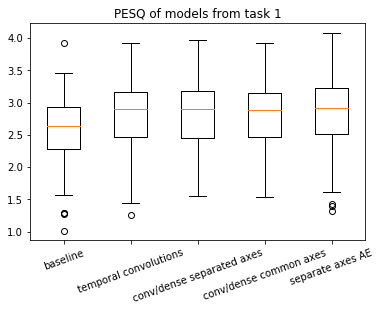

In [13]:
plot_model_names = ["baseline", "temporal convolutions", "conv/dense separated axes", "conv/dense common axes", "separate axes AE"]
plt.boxplot(quality_arrays, labels=plot_model_names)
plt.xticks(rotation=20)
plt.title("PESQ of models from task 1")
plt.show()

<Container object of 5 artists>

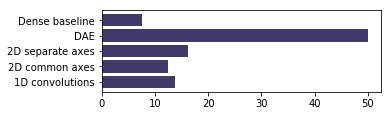

In [38]:
preferences = np.stack(quality_arrays).argmax(0)
from collections import Counter

c = Counter(preferences)
prefs = [c[x] for x in sorted(c.keys())]
plt.figure(figsize=(5,1.5))
plot_model_names = ["Dense baseline", "1D convolutions", "2D separate axes", "2D common axes", "DAE"]
plt.barh(plot_model_names, np.array(prefs) / 80 * 100, color="#423b6a")


In [36]:
# log power MSE

"""
inp, gtruth = test
gtruth = STD * gtruth + MEAN
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
logmse=[]
for i in range(gtruth.shape[0]):
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
print("Baseline log-power MSE:", np.array(logmse).mean())
"""

for name, mdl in zip(experiment_names[0::5], models[0::5]):
    logmse=[]
    preds = np.zeros([gtruth.shape[0], 1248, 257], np.float32)
    for i in range(gtruth.shape[0]):
        preds[i] = mdl.predict(inp[i:i+1])
    preds[:, :, :129] = inp[:, :, :129]
    preds = STD * preds + MEAN
    for i in range(gtruth.shape[0]):
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
    print("Log-power MSE of {}:".format(name), np.array(logmse).mean(), "+-", np.array(logmse).std())



Log-power MSE of ./runs/1540811443.31866: 4.423875 +- 0.79644096
Log-power MSE of ./runs/1540816118.892748: 4.475132 +- 0.86888206


In [11]:
# log-spectral distance


inp, gtruth = test
gruth = gtruth * STD + MEAN
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
lsd = []
innermost = (((-preds) - (-gtruth)) / np.log(10)) ** 2
for i in range(gtruth.shape[0]):
    inner = innermost[i, :, :]
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    inner = inner[:length]
    sublsd = []
    for t in range(length):
        step = 2 / 513
        frame = inner[t]
        integral = frame.sum()
        sublsd.append(np.sqrt(step * integral))
    lsd.append(np.array(sublsd).mean())
print("Log-spectral distance of baseline:", np.array(lsd).mean())

for name, mdl in zip(experiment_names, models):
    preds = STD * mdl.predict(inp) + MEAN
    lsd = []
    innermost = (((-preds) - (-gtruth)) / np.log(10)) ** 2
    for i in range(gtruth.shape[0]):
        inner = innermost[i, :, :]
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        inner = inner[:length]
        sublsd = []
        for t in range(length):
            step = 2 / 513
            frame = inner[t]
            integral = frame.sum()
            sublsd.append(np.sqrt(step * integral))
        lsd.append(np.array(sublsd).mean())
    print("Log-spectral distance of {}:".format(name), np.array(lsd).mean(), "+-", np.array(lsd).std())

Log-spectral distance of baseline: 5.0475292638123985
Log-spectral distance of ./runs/1538495798.0744123: 7.403970430608278 +- 0.241481100139091
Log-spectral distance of ./runs/1538504597.4488058: 7.418889435034627 +- 0.2374114228769503
Log-spectral distance of ./runs/1538507862.4013004: 7.378589374998302 +- 0.23601681200358943
Log-spectral distance of ./runs/1538512005.2587183: 7.397871285149712 +- 0.2403678000492443
Log-spectral distance of ./runs/1538518712.1716878: 7.406891786943916 +- 0.23343155849074415
Log-spectral distance of ./runs/1538534130.8271744: 7.372297684968936 +- 0.2469443769323787


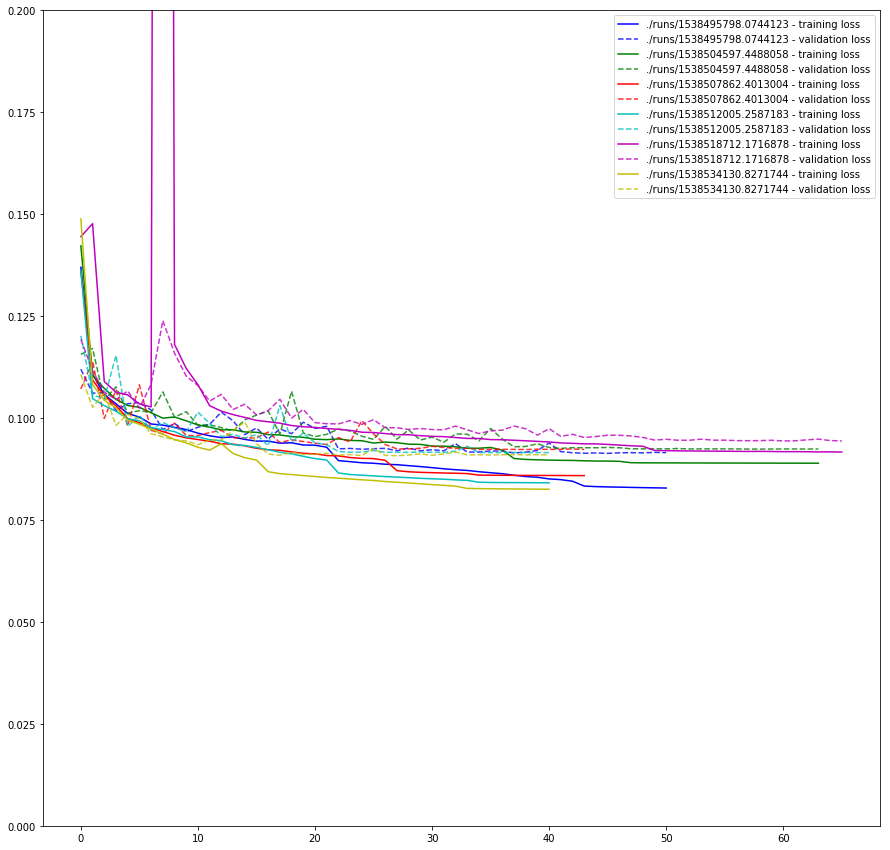

In [17]:
# Losses during training

legend_labels = []
colors = "bgrcmykbgrcmyk"
train_linestyles = ["-"] * 7 + ["-."] * 7
val_linestyles = ["--"] * 7 + ["dotted"] * 7
plt.figure(figsize=(15,15))
for color, tl, vl, model in zip(colors, train_linestyles, val_linestyles, experiment_names):
    with open(model + "/history.pkl", "rb") as f:
        hist = pickle.load(f)
    loss = hist['loss']
    val_loss = hist['val_loss']
    plt.plot(loss, linestyle=tl, color=color)
    plt.plot(val_loss, linestyle=vl, color=color, alpha=0.8)
    legend_labels.append(model + " - training loss")
    legend_labels.append(model + " - validation loss")
plt.ylim(0, 0.2)
plt.legend(legend_labels)
plt.show()

# Conclusions

Results are consistent with the uncorrected case - this is interesting that the separate axes (model 4) performs better than common axes (model 5) - this should confirm that we should treat axes differently.

Should I cross-valid this as these are really small differences...

In [49]:
means = np.stack(quality_arrays).mean(0)
items = [x for x in means]
sorted_items = list(sorted(items))
indices = [items.index(x) for x in sorted_items]
array = [np.stack(quality_arrays)[:, index] for index in indices]

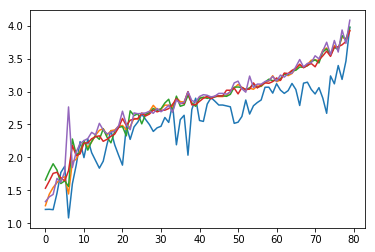

In [51]:
plt.plot(array)

In [55]:
np.stack(array).std(1).mean()

0.13149134993125236